In [1]:
!git clone https://github.com/liuzhimei/M2_coursework.git
%cd M2_coursework
!pwd

Cloning into 'M2_coursework'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 6), reused 26 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.57 MiB | 1.65 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/M2_coursework
/content/M2_coursework


In [2]:
!nvidia-smi

Mon Mar 24 13:47:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!nvidia-smi --gpu-reset

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.


In [4]:
import torch
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from accelerate import Accelerator
from torch.utils.data import DataLoader, TensorDataset
from src.qwen import load_qwen
from src.preprocessor import preprocess_all_time_series
from lora.lora_skeleton import LoRALinear, process_sequences

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# LoRA

In [5]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

In [6]:
model, tokenizer = load_qwen()
lora_rank = 4

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)
# ^These are the parts that will actually be trained!

# Process the data into sequences of text
train_texts, val_texts = preprocess_all_time_series(trajectories)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

## Model training

In [7]:
# Defines the maximum context length
max_ctx_length = 512

train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)

train_input_ids = torch.tensor(train_input_ids)
val_input_ids = torch.tensor(val_input_ids)

batch_size = 4
learning_rate = 1e-5

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-7-f12df655f808>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input_ids = torch.tensor(train_input_ids)
<ipython-input-7-f12df655f808>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_input_ids = torch.tensor(val_input_ids)


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.06it/s]


Step 1000 | Train Loss: 0.3660 | Val Loss: 0.2317


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.07it/s]


Step 2000 | Train Loss: 0.2347 | Val Loss: 0.2129


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.07it/s]


Step 3000 | Train Loss: 0.2164 | Val Loss: 0.1987


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.07it/s]


Step 4000 | Train Loss: 0.2040 | Val Loss: 0.1890


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.07it/s]


Step 5000 | Train Loss: 0.1948 | Val Loss: 0.1814


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.07it/s]


Step 6000 | Train Loss: 0.1880 | Val Loss: 0.1759


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.06it/s]


Step 7000 | Train Loss: 0.1831 | Val Loss: 0.1721


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.06it/s]


Step 8000 | Train Loss: 0.1796 | Val Loss: 0.1693


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.06it/s]


Step 9000 | Train Loss: 0.1770 | Val Loss: 0.1669


Validating: 100%|██████████| 150/150 [00:21<00:00,  7.06it/s]


Step 10000 | Train Loss: 0.1748 | Val Loss: 0.1653


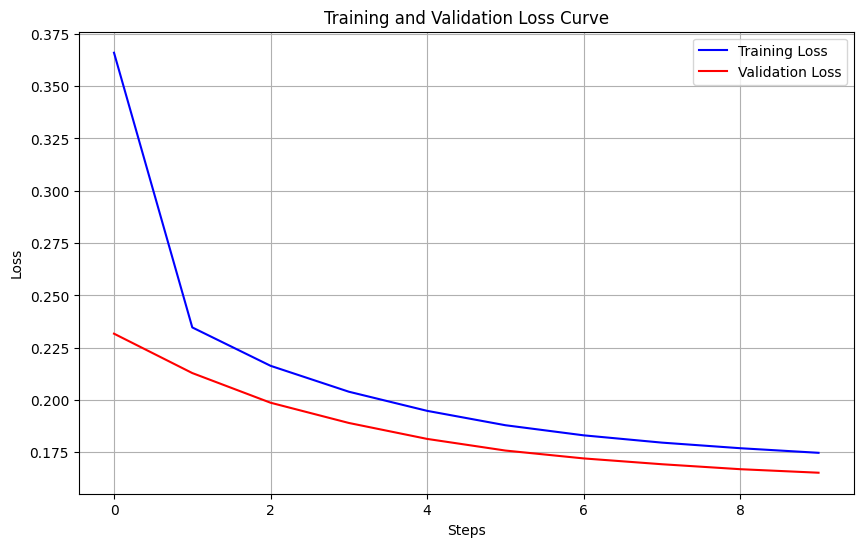

In [8]:
accelerator = Accelerator()
model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

# Initialize lists to track losses
train_losses = []
val_losses = []

model.train()
max_steps = 10000
steps = 0

# Validation interval (after how many steps we run validation)
val_interval = 50  # e.g., validate every 500 steps

# Training loop
while steps < max_steps:
    total_train_loss = 0
    num_batches_train = 0

    progress_bar_train = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar_train:
        torch.cuda.empty_cache()

        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        accelerator.backward(loss) # with accelerator, batch is already on correct device
        optimizer.step()

        # Track loss
        total_train_loss += loss.item()
        num_batches_train += 1
        steps += 1

        # # After every batch or a set number of steps, append the training loss
        # train_losses.append(total_train_loss / num_batches_train)

        # progress_bar_train.set_postfix(loss=loss.item())
        if steps > max_steps:
            break

    train_losses.append(total_train_loss / len(train_loader.dataset))


    model.eval()
    total_val_loss = 0
    num_batches_val = 0
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc="Validating")
        for (batch,) in progress_bar_val:
            torch.cuda.empty_cache()

            outputs = model(batch, labels=batch)
            loss = outputs.loss

            total_val_loss += loss.item()
            num_batches_val += 1

    # avg_val_loss = total_val_loss / num_batches_val
    val_losses.append(total_val_loss / len(val_loader.dataset))

    # Print current training and validation loss
    print(f"Step {steps} | Train Loss: {total_train_loss / len(train_loader.dataset):.4f} | Val Loss: {total_val_loss / len(val_loader.dataset):.4f}")
    model.train()

# Plotting the loss curves after training is done
plt.figure(figsize=(10, 6))
plt.plot(range(10), train_losses, label="Training Loss", color='blue')
plt.plot(range(10), val_losses, label="Validation Loss", color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Compute performance metrics

In [ ]:
import torch.nn.functional as F

all_preds = []
all_labels = []
for (batch,) in tqdm(val_loader, desc="Evaluating"):
    with torch.no_grad():
        outputs = model(batch, labels=batch)
        logits = outputs.logits
        all_preds.append(logits)
        all_labels.append(batch)

all_preds = torch.cat(all_preds).detach().cpu()
all_labels = torch.cat(all_labels).detach().cpu()

mae = F.l1_loss(all_preds, all_labels)
mse = F.mse_loss(all_preds, all_labels)

print(f"\nMean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Evaluating:  20%|██        | 30/150 [00:04<00:17,  6.84it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.16 GiB. GPU 0 has a total capacity of 39.56 GiB of which 972.88 MiB is free. Process 15203 has 38.60 GiB memory in use. Of the allocated memory 37.93 GiB is allocated by PyTorch, and 173.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)